In [ ]:
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable



# Data Preprocessing

In [ ]:
df = pd.read_csv('Japan.csv.gz')
df_new = df.copy()
df_new.head()  # View the first few rows

,X,Y,Band_1
0,127.541668,45.633334,0.0
1,127.545834,45.633334,0.0
2,127.550001,45.633334,0.0
3,127.554168,45.633334,0.0
4,127.558334,45.633334,0.0


In [ ]:
df.rename(columns={'X': 'longitude'}, inplace=True)
df.rename(columns={'Y': 'latitude'}, inplace=True)
df.rename(columns={'Band_1': 'light_intensity'}, inplace=True)
df.to_csv('Japan_viirs.csv.gz',index=False)

In [ ]:
df

,longitude,latitude,light_intensity
0,127.541668,45.633334,0.0
1,127.545834,45.633334,0.0
2,127.550001,45.633334,0.0
3,127.554168,45.633334,0.0
4,127.558334,45.633334,0.0
...,...,...,...
19572635,147.387501,28.533334,0.0
19572636,147.391668,28.533334,0.0
19572637,147.395835,28.533334,0.0
19572638,147.400001,28.533334,0.0


In [ ]:
# Define bounds for Tokyo (smart city)
tokyo_bounds = {
    "min_lat": 35.61,
    "max_lat": 35.83,
    "min_lon": 139.56,
    "max_lon": 139.91
}

# Define bounds for Tottori (developing city)
tottori_bounds = {
    "min_lat": 35.36,
    "max_lat": 35.57,
    "min_lon": 133.94,
    "max_lon": 134.50
}

# Filter data for Tokyo
tokyo_data = df[
    (df['latitude'] >= tokyo_bounds['min_lat']) &
    (df['latitude'] <= tokyo_bounds['max_lat']) &
    (df['longitude'] >= tokyo_bounds['min_lon']) &
    (df['longitude'] <= tokyo_bounds['max_lon'])
]

# Filter data for Tottori
tottori_data = df[
    (df['latitude'] >= tottori_bounds['min_lat']) &
    (df['latitude'] <= tottori_bounds['max_lat']) &
    (df['longitude'] >= tottori_bounds['min_lon']) &
    (df['longitude'] <= tottori_bounds['max_lon'])
]

# Add a city column to identify data from each city
tokyo_data = tokyo_data.copy()  # Create a copy to avoid modifying a slice
tottori_data = tottori_data.copy()  # Create a copy to avoid modifying a slice

tokyo_data.loc[:, 'city'] = 'Tokyo'
tottori_data.loc[:, 'city'] = 'Tottori'

# Combine Tokyo and Tottori data into a single DataFrame
viirs_data = pd.concat([tokyo_data, tottori_data], ignore_index=True)

# Save the combined data to a new CSV file
viirs_data.to_csv("Japan_data.csv", index=False)

print("Combined data for Tokyo and Tottori saved.")

# Save the filtered data to new CSV files
tokyo_data.to_csv("tokyo_data.csv", index=False)
tottori_data.to_csv("tottori_data.csv", index=False)

print("Filtered data saved for Tokyo and Tottori.")


Combined data for Tokyo and Tottori saved.
Filtered data saved for Tokyo and Tottori.


In [ ]:
viirs_data

,longitude,latitude,light_intensity,city
0,139.562501,35.829167,21.827122,Tokyo
1,139.566668,35.829167,20.948105,Tokyo
2,139.570834,35.829167,23.337433,Tokyo
3,139.575001,35.829167,25.592182,Tokyo
4,139.579168,35.829167,24.239080,Tokyo
...,...,...,...,...
11147,134.479168,35.362500,0.320583,Tottori
11148,134.483334,35.362500,0.277542,Tottori
11149,134.487501,35.362500,0.281790,Tottori
11150,134.491668,35.362500,0.302659,Tottori


In [ ]:
import geopandas as gpd

# List of GeoJSON files to merge
geojson_files = [
    "tiles_in_japan_Q1.geojson",
    "tiles_in_japan_Q2.geojson",
    "tiles_in_japan_Q3.geojson",
    "tiles_in_japan_Q4.geojson"
]

# Load all GeoJSON files into GeoDataFrames
geo_dataframes = [gpd.read_file(file) for file in geojson_files]

# Concatenate all GeoDataFrames
merged_gdf = gpd.GeoDataFrame(pd.concat(geo_dataframes, ignore_index=True))

# Set the CRS (if not already set or if they differ, you might need to align them first)
if not merged_gdf.crs:
    merged_gdf.set_crs(epsg=4326, inplace=True)  # Assuming WGS84 CRS

# Save the merged GeoDataFrame to a new GeoJSON file
merged_gdf.to_file("tiles_in_japan.geojson", driver="GeoJSON")

print("Merged GeoJSON file saved as 'merged_output.geojson'")

Merged GeoJSON file saved as 'merged_output.geojson'


# Data Integration

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np

# Load Ookla dataset
ookla_file = "tiles_in_japan.geojson"  # Replace with your Ookla GeoJSON file path
ookla_data = gpd.read_file(ookla_file)

# Load VIIRS dataset
viirs_file = "Japan_data.csv"  # Replace with your VIIRS CSV file path
viirs_data = pd.read_csv(viirs_file)

# Convert VIIRS data into a GeoDataFrame
geometry = [Point(xy) for xy in zip(viirs_data['longitude'], viirs_data['latitude'])]
viirs_gdf = gpd.GeoDataFrame(viirs_data, geometry=geometry, crs="EPSG:4326")

# Ensure both datasets use the same CRS
if ookla_data.crs != viirs_gdf.crs:
    viirs_gdf = viirs_gdf.to_crs(ookla_data.crs)

# Perform spatial join
print("Performing spatial join...")
viirs_with_speed = gpd.sjoin(
    viirs_gdf,
    ookla_data,
    how="left",
    predicate="intersects",
    lsuffix="viirs",
    rsuffix="ookla"
)

# Inspect the column names to confirm correct longitude and latitude columns
print("Columns in viirs_with_speed after spatial join:", viirs_with_speed.columns)

# Drop duplicates based on VIIRS geometry
# Update with the actual column names if suffixes were added
viirs_with_speed = viirs_with_speed.drop_duplicates(subset=["longitude", "latitude"])


# Handle unmatched points using nearest neighbor matching
unmatched = viirs_with_speed[viirs_with_speed['avg_d_kbps'].isna()]
if not unmatched.empty:
    print("Handling unmatched points with nearest neighbor matching...")

    # Ensure geometry is Point by using centroids for Ookla data
    ookla_centroids = ookla_data.geometry.centroid

    # Build KDTree for Ookla centroids
    ookla_coords = np.array(list(zip(ookla_centroids.x, ookla_centroids.y)))
    viirs_coords = np.array(list(zip(unmatched.geometry.x, unmatched.geometry.y)))
    tree = cKDTree(ookla_coords)

    # Find nearest neighbors
    distances, indices = tree.query(viirs_coords, k=1)

    # Assign nearest neighbor data to unmatched points
    nearest_data = ookla_data.iloc[indices].reset_index(drop=True)
    unmatched.loc[:, 'avg_d_mbps'] = nearest_data['avg_d_mbps'].values
    unmatched.loc[:, 'avg_u_mbps'] = nearest_data['avg_u_mbps'].values
    unmatched.loc[:, 'avg_lat_ms'] = nearest_data['avg_lat_ms'].values
    unmatched.loc[:, 'tests'] = nearest_data['tests'].values
    unmatched.loc[:, 'devices'] = nearest_data['devices'].values
    unmatched.loc[:, 'Quarter'] = nearest_data['Quarter'].values

    # Combine matched and unmatched points
    viirs_with_speed.update(unmatched)

# Save the final merged dataset
output_file = "viirs_ookla_2020_deduplicated.csv"
viirs_with_speed.drop(columns="geometry").to_csv(output_file, index=False)

print(f"Merged dataset saved to {output_file}")


Performing spatial join...
Columns in viirs_with_speed after spatial join: Index(['longitude', 'latitude', 'light_intensity', 'city', 'geometry',
       'index_ookla', 'quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms',
       'tests', 'devices', 'index_right', 'shapeName', 'shapeISO', 'shapeID',
       'shapeGroup', 'shapeType', 'avg_d_mbps', 'avg_u_mbps'],
      dtype='object')
Handling unmatched points with nearest neighbor matching...


C:\Users\hp\AppData\Local\Temp\ipykernel_8812\2604313284.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ookla_centroids = ookla_data.geometry.centroid


Merged dataset saved to viirs_ookla_2020_deduplicated.csv


# Data cleaning

In [ ]:
df = pd.read_csv("viirs_ookla_2020_deduplicated.csv")
print(df.shape)
print(df.isna().sum())

(11152, 20)
longitude             0
latitude              0
light_intensity       0
city                  0
index_ookla        6555
quadkey            6555
avg_d_kbps            0
avg_u_kbps            0
avg_lat_ms            0
tests                 0
devices               0
index_right        6555
shapeName          6555
shapeISO           6555
shapeID            6555
shapeGroup         6555
shapeType          6555
avg_d_mbps            0
avg_u_mbps            0
Quarter               0
dtype: int64


In [ ]:
print(viirs_data.shape)
print(df.shape)
print(ookla_data.shape)

(11152, 4)
(11152, 19)
(301412, 15)


In [ ]:
df = df.drop(columns=['index_ookla', 'quadkey', 'shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType', 'index_right','avg_u_kbps','avg_d_kbps'])
df

,longitude,latitude,light_intensity,city,avg_lat_ms,tests,devices,avg_d_mbps,avg_u_mbps,Quarter
0,139.562501,35.829167,21.827122,Tokyo,10.0,11.0,4.0,96.278,45.465,4.0
1,139.566668,35.829167,20.948105,Tokyo,26.0,13.0,8.0,61.070,66.985,1.0
2,139.570834,35.829167,23.337433,Tokyo,19.0,21.0,9.0,119.455,90.585,4.0
3,139.575001,35.829167,25.592182,Tokyo,19.0,21.0,9.0,119.455,90.585,4.0
4,139.579168,35.829167,24.239080,Tokyo,10.0,26.0,11.0,88.415,85.376,2.0
...,...,...,...,...,...,...,...,...,...,...
11147,134.479168,35.362500,0.320583,Tottori,16.0,1.0,1.0,9.271,12.137,1.0
11148,134.483334,35.362500,0.277542,Tottori,16.0,1.0,1.0,9.271,12.137,1.0
11149,134.487501,35.362500,0.281790,Tottori,16.0,1.0,1.0,9.271,12.137,1.0
11150,134.491668,35.362500,0.302659,Tottori,16.0,1.0,1.0,9.271,12.137,1.0


In [ ]:
print(df.shape)
print(df.isna().sum())

(11152, 10)
longitude          0
latitude           0
light_intensity    0
city               0
avg_lat_ms         0
tests              0
devices            0
avg_d_mbps         0
avg_u_mbps         0
Quarter            0
dtype: int64


In [ ]:
df.to_csv("Merged_clean.csv",index=False)

# EDA

In [ ]:
df2 = pd.read_csv('Merged_clean.csv')
df2.head()

,longitude,latitude,light_intensity,city,avg_lat_ms,tests,devices,avg_d_mbps,avg_u_mbps,Quarter
0,139.562501,35.829167,21.827122,Tokyo,10.0,11.0,4.0,96.278,45.465,4.0
1,139.566668,35.829167,20.948105,Tokyo,26.0,13.0,8.0,61.070,66.985,1.0
2,139.570834,35.829167,23.337433,Tokyo,19.0,21.0,9.0,119.455,90.585,4.0
3,139.575001,35.829167,25.592182,Tokyo,19.0,21.0,9.0,119.455,90.585,4.0
4,139.579168,35.829167,24.239080,Tokyo,10.0,26.0,11.0,88.415,85.376,2.0


In [ ]:
numeric_data = df2.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

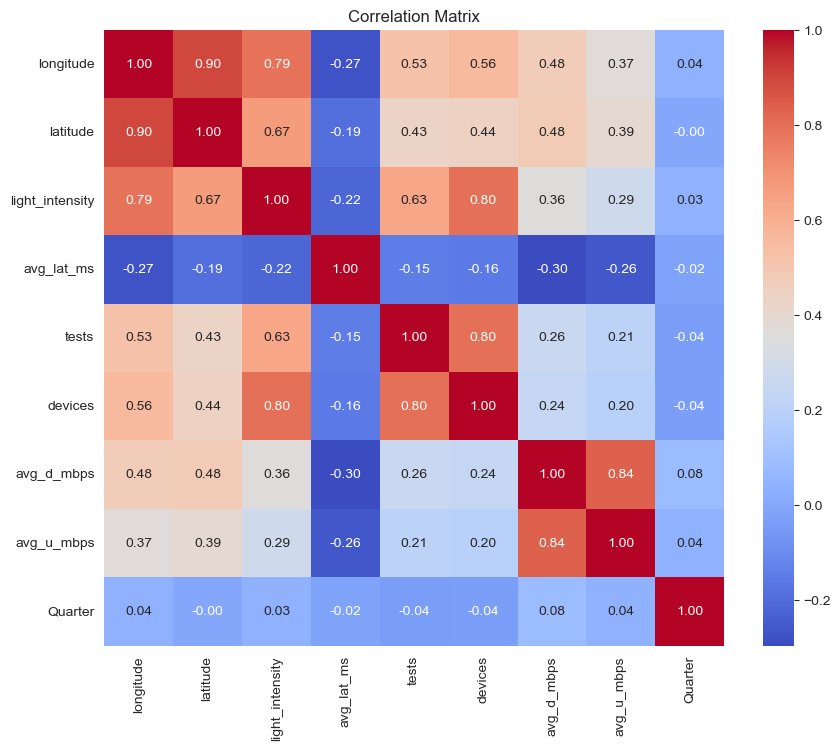

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
Tokyo_df = df2[df2['city'] == 'Tokyo']
tokyo_numeric_data = df2.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
tokyo_correlation_matrix = tokyo_numeric_data.corr()

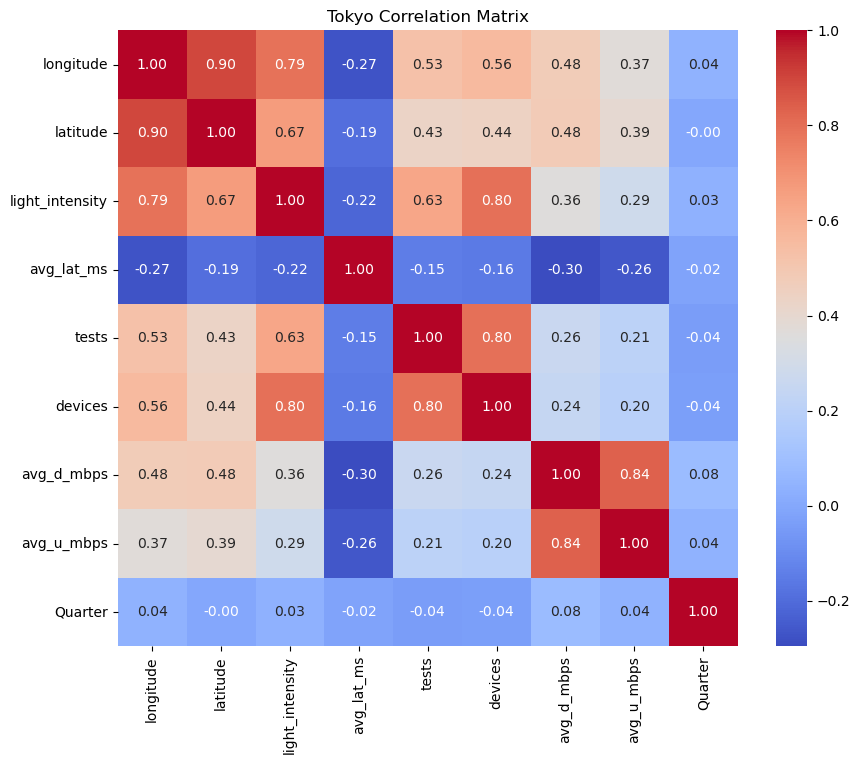

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(tokyo_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Tokyo Correlation Matrix")
plt.show()

In [ ]:
Tottori_df = df2[df2['city'] == 'Tottori']
tottori_numeric_data = df2.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
tottori_correlation_matrix = tottori_numeric_data.corr()

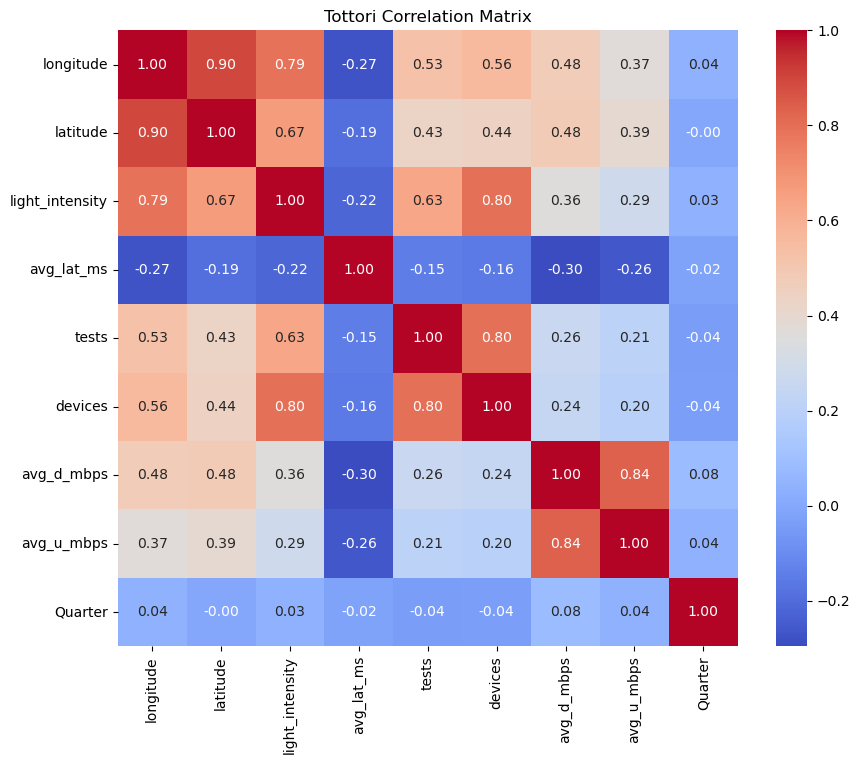

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(tottori_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Tottori Correlation Matrix")
plt.show()

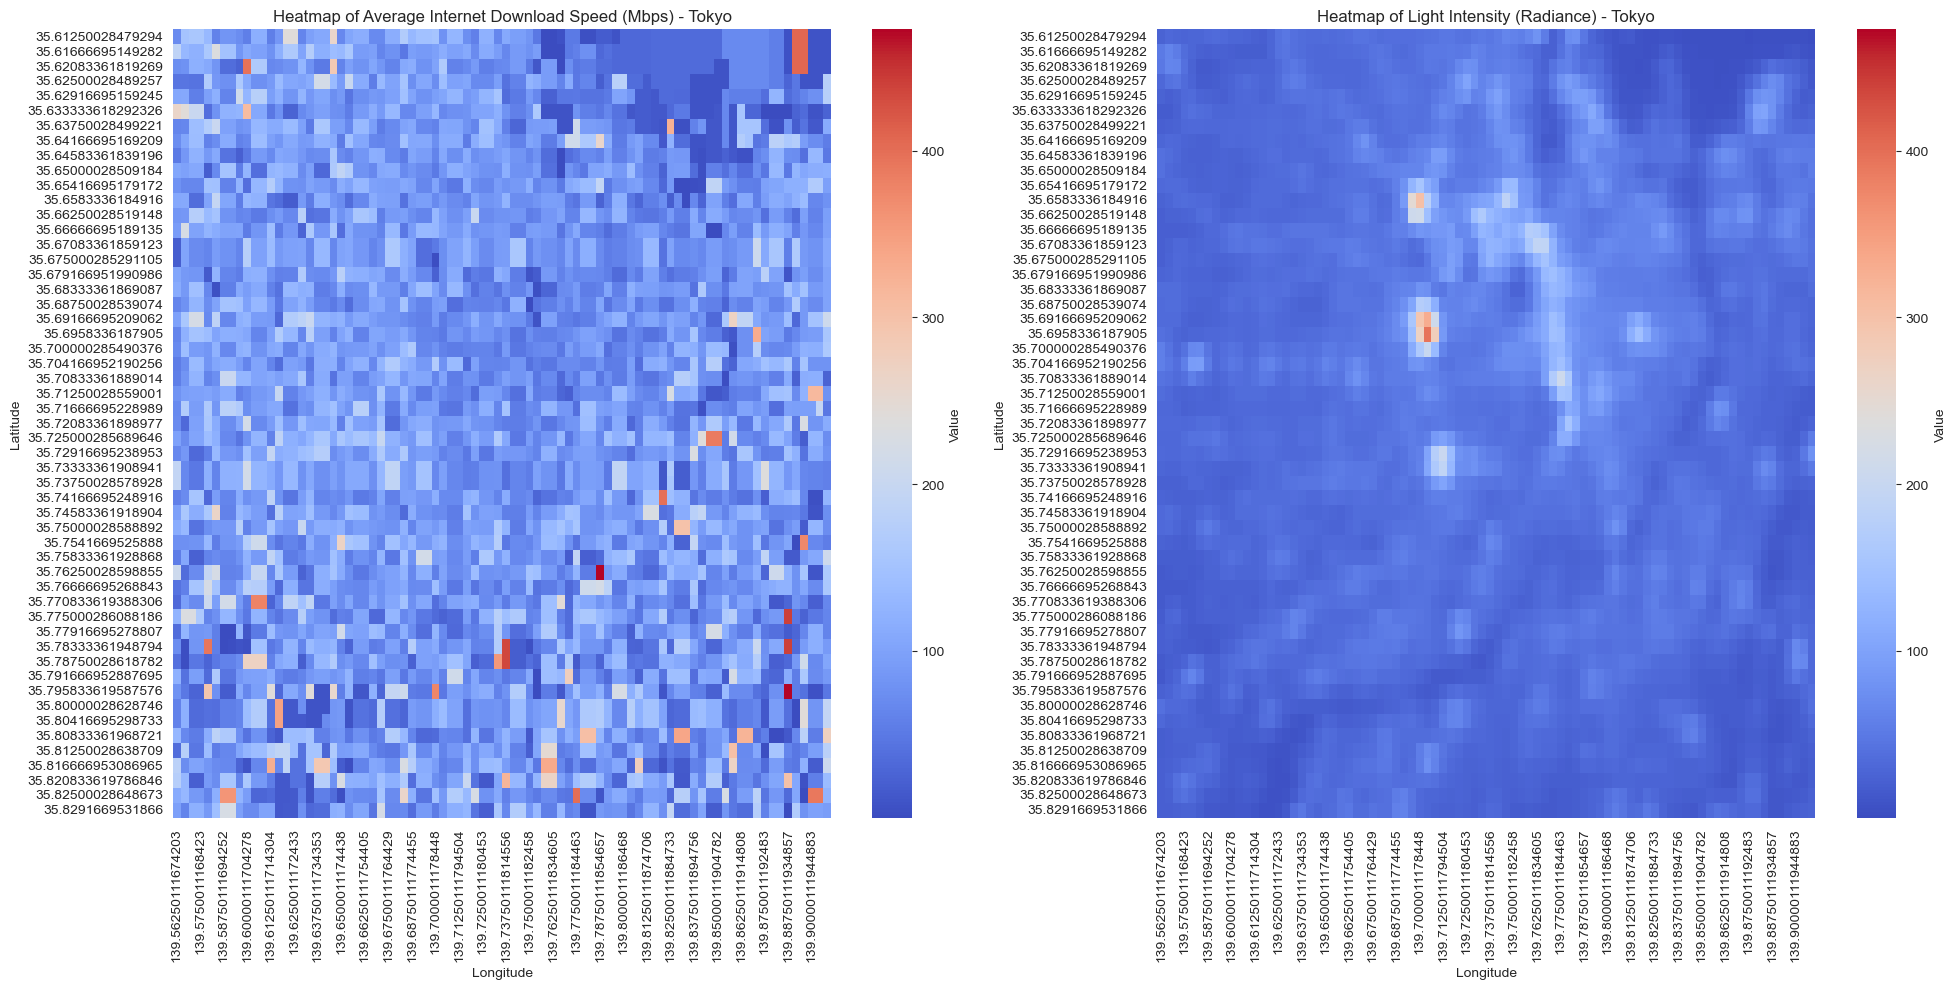

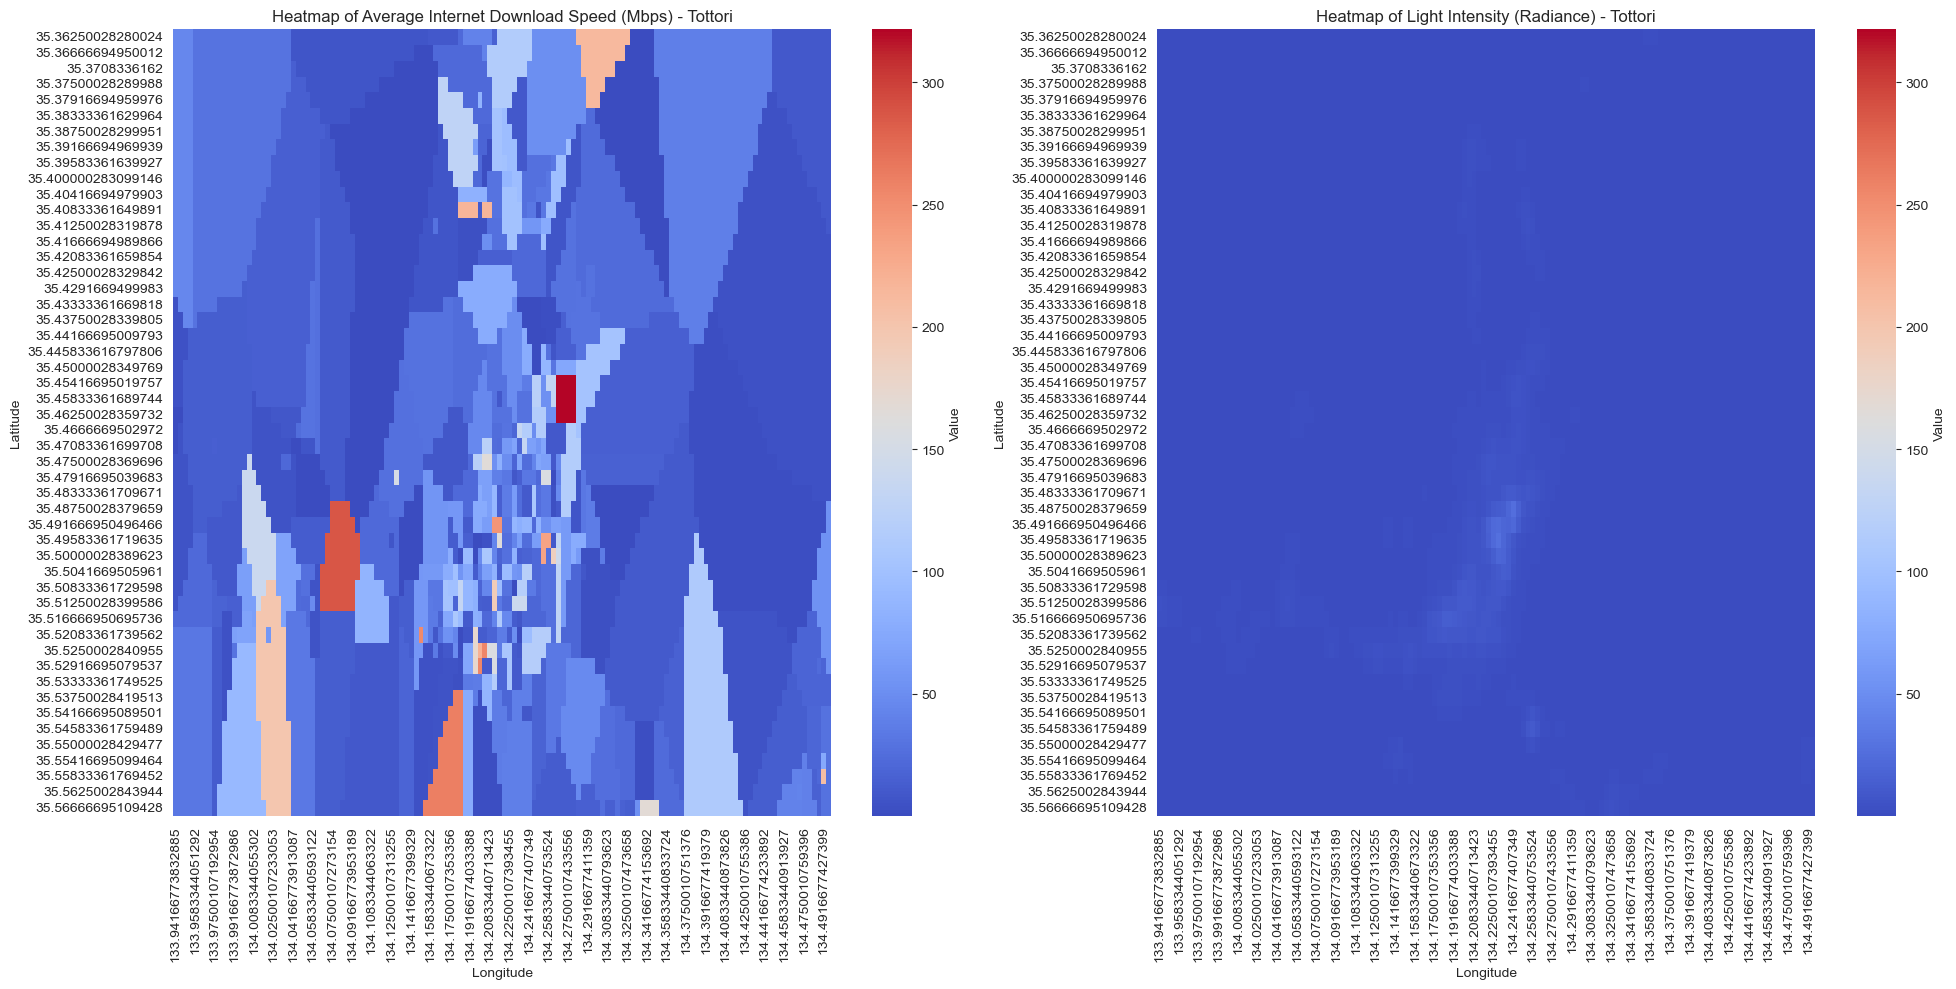

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df2 = pd.read_csv('Merged_clean.csv')
df2.head()
# Filter data for Tokyo and Tottori
cities = df2['city'].unique()

for city in cities:
    city_data = df2[df2['city'] == city]

    # Create pivot tables for heatmaps
    heatmap_data_speed = city_data.pivot_table(
        index='latitude',
        columns='longitude',
        values='avg_d_mbps',
        aggfunc='mean'
    )
    heatmap_data_radiance = city_data.pivot_table(
        index='latitude',
        columns='longitude',
        values='light_intensity',
        aggfunc='mean'
    )

    # Skip if pivot tables are empty
    if heatmap_data_speed.empty or heatmap_data_radiance.empty:
        print(f"Skipping city: {city} due to insufficient data.")
        continue

    # Determine the common color range
    vmin = min(heatmap_data_speed.min().min(), heatmap_data_radiance.min().min())
    vmax = max(heatmap_data_speed.max().max(), heatmap_data_radiance.max().max())

    # Avoid identical vmin and vmax
    if vmin == vmax:
        vmin -= 1
        vmax += 1

    # Plot the heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    sns.heatmap(heatmap_data_speed, cmap='coolwarm', cbar_kws={'label': 'Value'}, vmin=vmin, vmax=vmax, ax=axes[0])
    axes[0].set_title(f'Heatmap of Average Internet Download Speed (Mbps) - {city}')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')

    sns.heatmap(heatmap_data_radiance, cmap='coolwarm', cbar_kws={'label': 'Value'}, vmin=vmin, vmax=vmax, ax=axes[1])
    axes[1].set_title(f'Heatmap of Light Intensity (Radiance) - {city}')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()


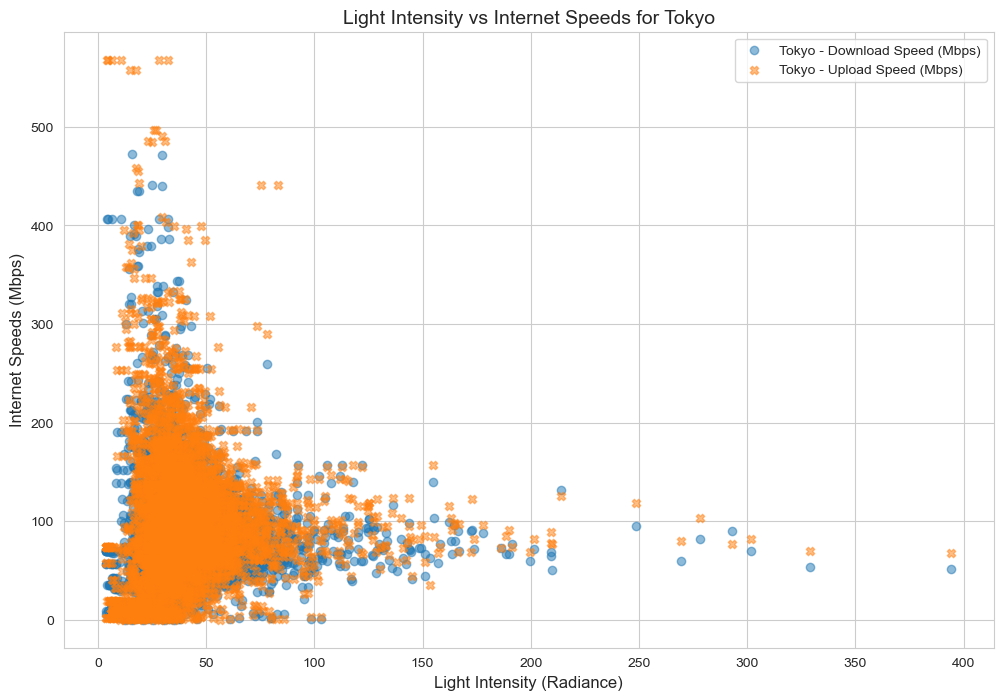

In [ ]:
filtered_data = df2[df2['city'].isin(['Tokyo', 'Tottori'])]

# Scatterplot for both cities (Tokyo and Trotti) for Light Intensity vs Internet Speeds
plt.figure(figsize=(12, 8))

# Scatter for Tokyo
tokyo_data = filtered_data[filtered_data['city'] == 'Tokyo']
plt.scatter(tokyo_data['light_intensity'], tokyo_data['avg_d_mbps'], label="Tokyo - Download Speed (Mbps)", alpha=0.5)
plt.scatter(tokyo_data['light_intensity'], tokyo_data['avg_u_mbps'], label="Tokyo - Upload Speed (Mbps)", alpha=0.5, marker='X')

# Scatter for Trotti
#trotti_data = filtered_data[filtered_data['city'] == 'Trotti']
#plt.scatter(trotti_data['light_intensity'], trotti_data['avg_d_mbps'], label="Trotti - Download Speed (Mbps)", alpha=0.5)
#plt.scatter(trotti_data['light_intensity'], trotti_data['avg_u_mbps'], label="Trotti - Upload Speed (Mbps)", alpha=0.5, marker='X')

# Titles and labels
plt.title("Light Intensity vs Internet Speeds for Tokyo", fontsize=14)
plt.xlabel("Light Intensity (Radiance)", fontsize=12)
plt.ylabel("Internet Speeds (Mbps)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

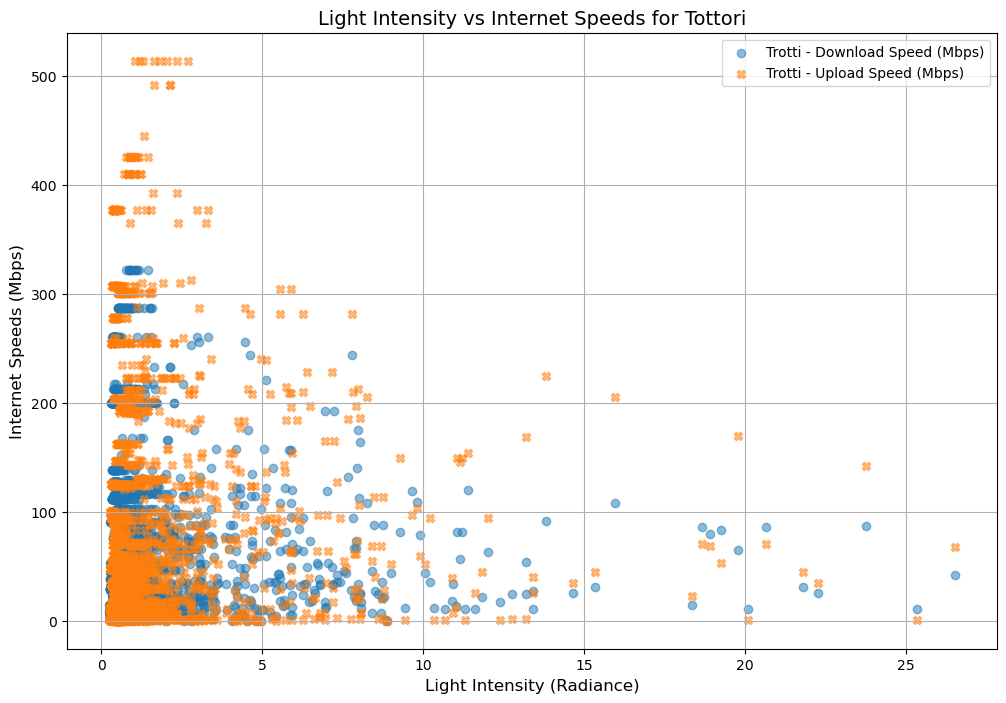

In [ ]:
filtered_data = df2[df2['city'].isin(['Tokyo', 'Tottori'])]

# Scatterplot for both cities (Tokyo and Trotti) for Light Intensity vs Internet Speeds
plt.figure(figsize=(12, 8))

# Scatter for Tokyo
#tokyo_data = filtered_data[filtered_data['city'] == 'Tokyo']
#plt.scatter(tokyo_data['light_intensity'], tokyo_data['avg_d_mbps'], label="Tokyo - Download Speed (Mbps)", alpha=0.5)
#plt.scatter(tokyo_data['light_intensity'], tokyo_data['avg_u_mbps'], label="Tokyo - Upload Speed (Mbps)", alpha=0.5, marker='X')

# Scatter for Trotti
trotti_data = filtered_data[filtered_data['city'] == 'Tottori']
plt.scatter(trotti_data['light_intensity'], trotti_data['avg_d_mbps'], label="Trotti - Download Speed (Mbps)", alpha=0.5)
plt.scatter(trotti_data['light_intensity'], trotti_data['avg_u_mbps'], label="Trotti - Upload Speed (Mbps)", alpha=0.5, marker='X')

# Titles and labels
plt.title("Light Intensity vs Internet Speeds for Tottori", fontsize=14)
plt.xlabel("Light Intensity (Radiance)", fontsize=12)
plt.ylabel("Internet Speeds (Mbps)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

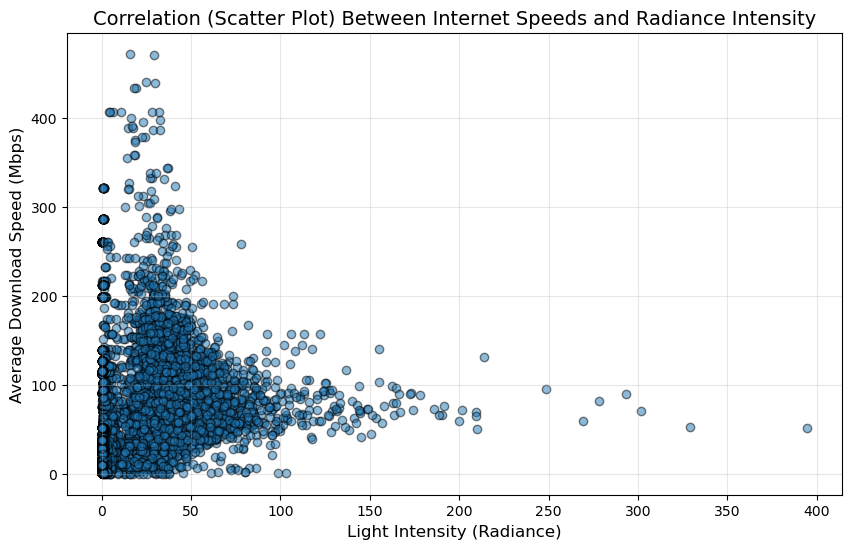

In [ ]:
# Scatter plot to analyze correlation between internet speeds and radiance intensity
plt.figure(figsize=(10, 6))
plt.scatter(df2['light_intensity'], df2['avg_d_mbps'], alpha=0.5, edgecolor='k')
plt.title('Correlation (Scatter Plot) Between Internet Speeds and Radiance Intensity', fontsize=14)
plt.xlabel('Light Intensity (Radiance)', fontsize=12)
plt.ylabel('Average Download Speed (Mbps)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

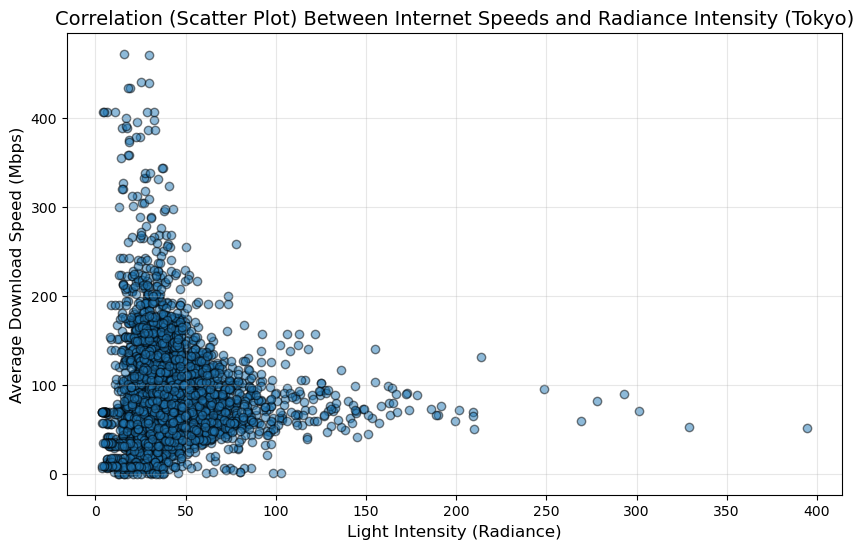

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(tokyo_data['light_intensity'], tokyo_data['avg_d_mbps'], alpha=0.5, edgecolor='k')
plt.title('Correlation (Scatter Plot) Between Internet Speeds and Radiance Intensity (Tokyo)', fontsize=14)
plt.xlabel('Light Intensity (Radiance)', fontsize=12)
plt.ylabel('Average Download Speed (Mbps)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

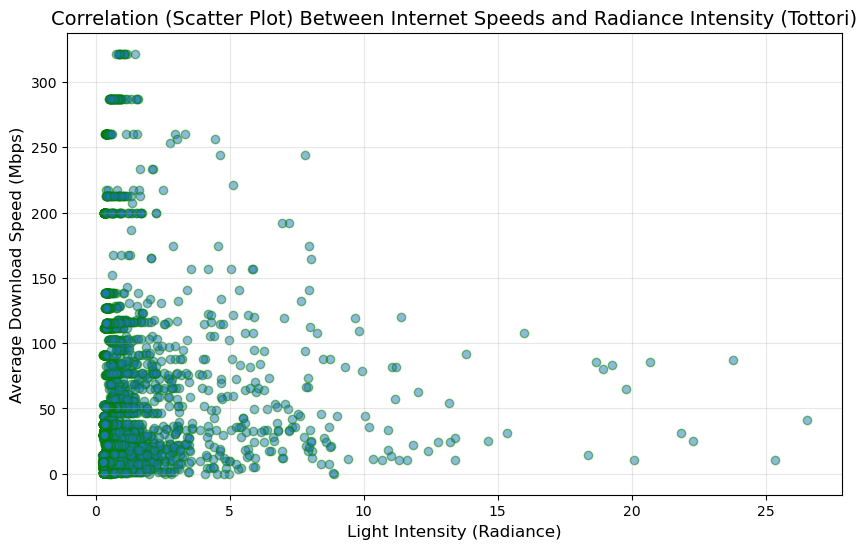

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(tottori_data['light_intensity'], tottori_data['avg_d_mbps'], alpha=0.5, edgecolor='g')
plt.title('Correlation (Scatter Plot) Between Internet Speeds and Radiance Intensity (Tottori)', fontsize=14)
plt.xlabel('Light Intensity (Radiance)', fontsize=12)
plt.ylabel('Average Download Speed (Mbps)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

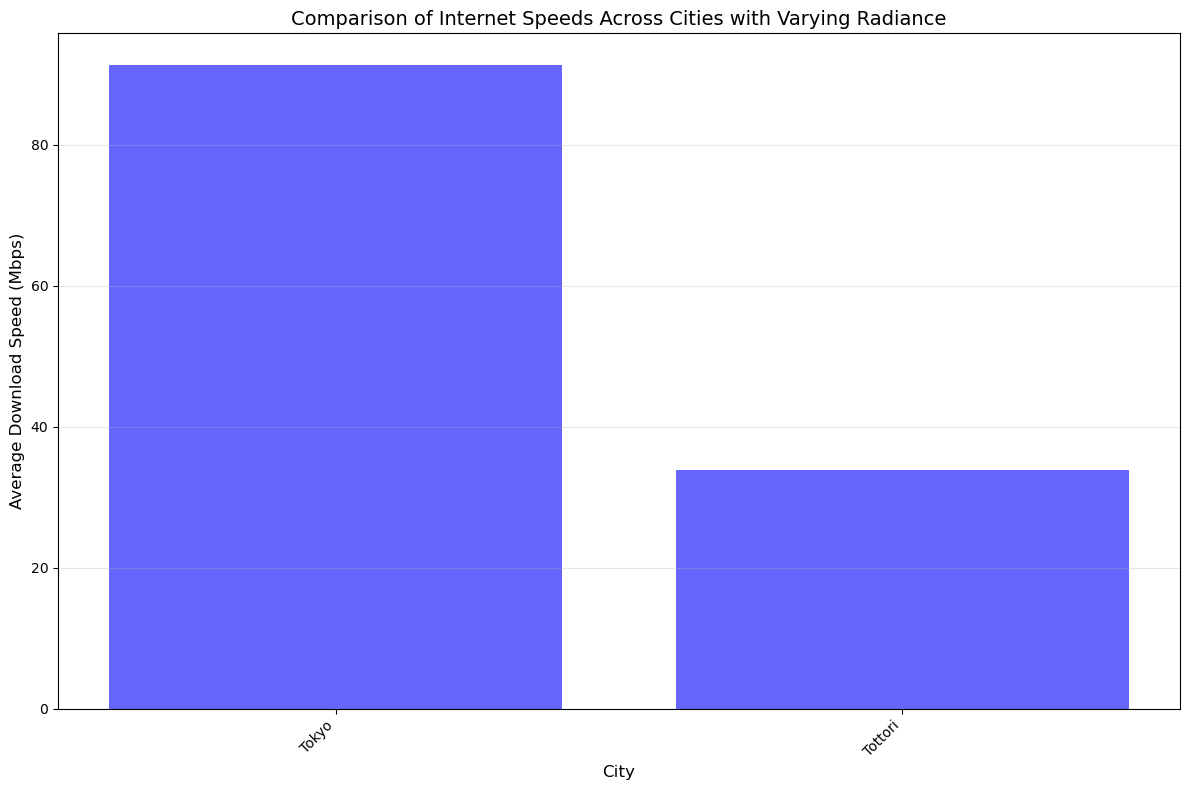

In [ ]:

city_data = df2.groupby('city').agg({
    'light_intensity': 'mean',
    'avg_d_mbps': 'mean'
}).reset_index()

# Sort cities by radiance for better visualization
city_data = city_data.sort_values(by='light_intensity', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.bar(city_data['city'], city_data['avg_d_mbps'], color='blue', alpha=0.6)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Comparison of Internet Speeds Across Cities with Varying Radiance', fontsize=14)
plt.xlabel('City', fontsize=12)
plt.ylabel('Average Download Speed (Mbps)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

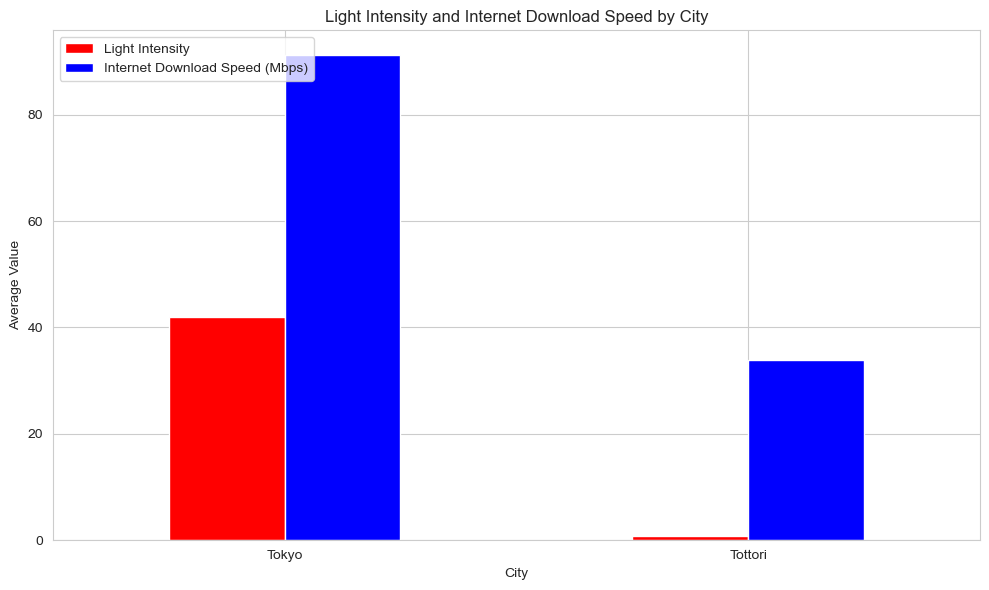

In [ ]:
filtered_data = df2[df2['city'].isin(['Tokyo', 'Tottori'])]

# Group by city and calculate mean for light intensity and average download speed
grouped_data = filtered_data.groupby('city')[['light_intensity', 'avg_d_mbps']].mean()

# Plot the bar chart
ax = grouped_data.plot(kind='bar', figsize=(10, 6), color=['red', 'blue'])
plt.title('Light Intensity and Internet Download Speed by City')
plt.ylabel('Average Value')
plt.xlabel('City')
plt.xticks(rotation=0)
plt.legend(['Light Intensity', 'Internet Download Speed (Mbps)'], loc='upper left')
plt.tight_layout()
plt.show()

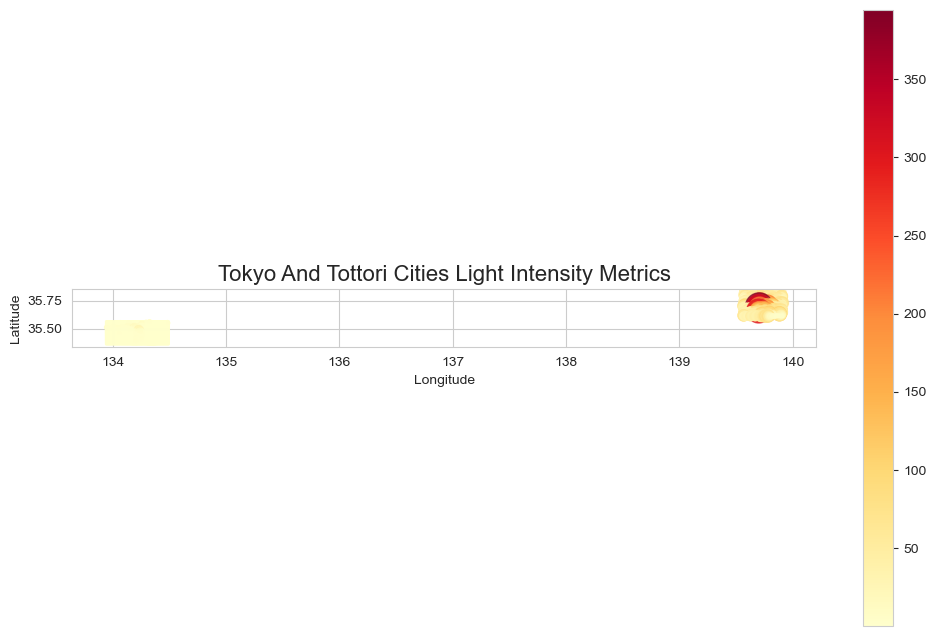

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point



# Convert the data into a GeoDataFrame
geometry = [Point(xy) for xy in zip(df2['longitude'], df2['latitude'])]
geo_df = gpd.GeoDataFrame(df2, geometry=geometry)

# Plot the geospatial overlay
fig, ax = plt.subplots(figsize=(12, 8))

# Plot light intensity (proxy for smart city regions)
geo_df.plot(
    column='light_intensity',
    cmap='YlOrRd',
    markersize=geo_df['light_intensity'],
    alpha=0.7,
    legend=True,
    ax=ax
)

# Overlay average download speeds
# geo_df.plot(
#     column='avg_d_mbps',
#     cmap='Blues',
#     markersize=geo_df['avg_d_mbps'] / 5,
#     alpha=0.5,
#     ax=ax,
#     legend=True
#)

# Customizing plot
ax.set_title("Tokyo And Tottori Cities Light Intensity Metrics", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()



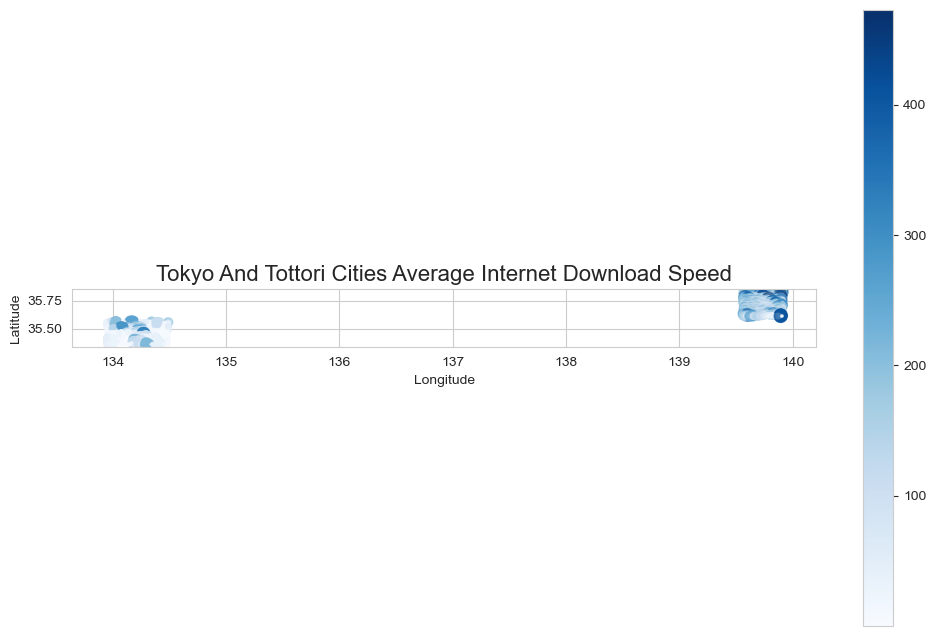

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point



# Convert the data into a GeoDataFrame
geometry = [Point(xy) for xy in zip(df2['longitude'], df2['latitude'])]
geo_df = gpd.GeoDataFrame(df2, geometry=geometry)

# Plot the geospatial overlay
fig, ax = plt.subplots(figsize=(12, 8))

# Plot light intensity (proxy for smart city regions)
# geo_df.plot(
#     column='light_intensity',
#     cmap='YlOrRd',
#     markersize=geo_df['light_intensity'],
#     alpha=0.7,
#     legend=True,
#     ax=ax
# )

#Overlay average download speeds
geo_df.plot(
    column='avg_d_mbps',
    cmap='Blues',
    markersize=geo_df['avg_d_mbps'] / 5,
    alpha=0.5,
    ax=ax,
    legend=True
)

# Customizing plot
ax.set_title("Tokyo And Tottori Cities Average Internet Download Speed", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()



In [ ]:
df2['Quarter'] = pd.Categorical(df2['Quarter'], ordered=True, categories=sorted(df2['Quarter'].unique()))
selected_cities = ["Tokyo", "Tottori"]

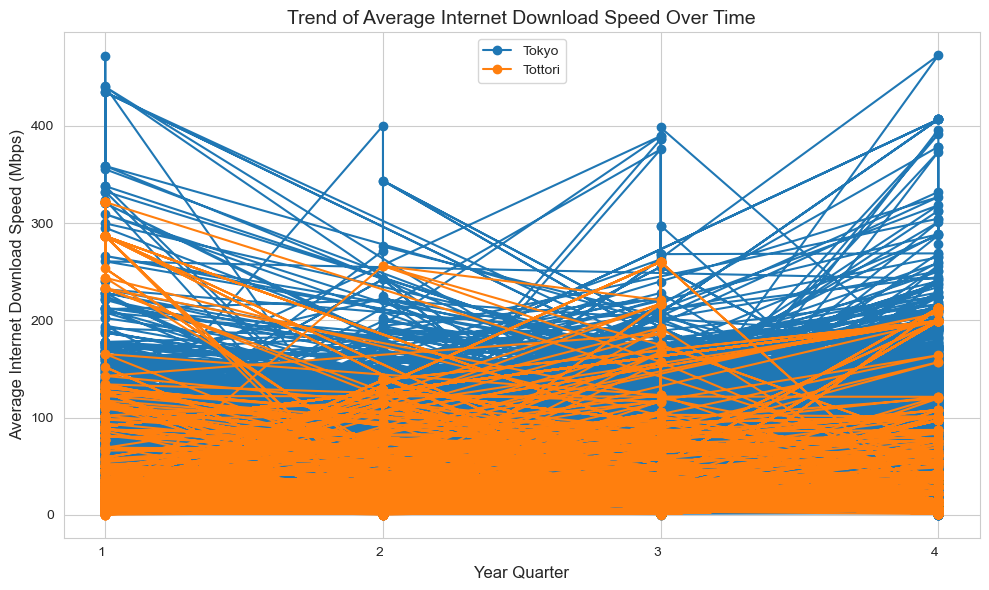

In [ ]:
# Plot for avg_d_mbps
metric = 'avg_d_mbps'

plt.figure(figsize=(10, 6))
for city in selected_cities:
    city_data = filtered_data[filtered_data['city'] == city]
    plt.plot(
        city_data['Quarter'],
        city_data[metric],
        label=city,
        marker='o'
    )

plt.title(f"Trend of Average Internet Download Speed Over Time", fontsize=14)
plt.xlabel("Year Quarter", fontsize=12)
plt.ylabel("Average Internet Download Speed (Mbps)", fontsize=12)
plt.xticks(ticks=[1, 2, 3, 4], labels=['1', '2', '3', '4'], ha="right", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

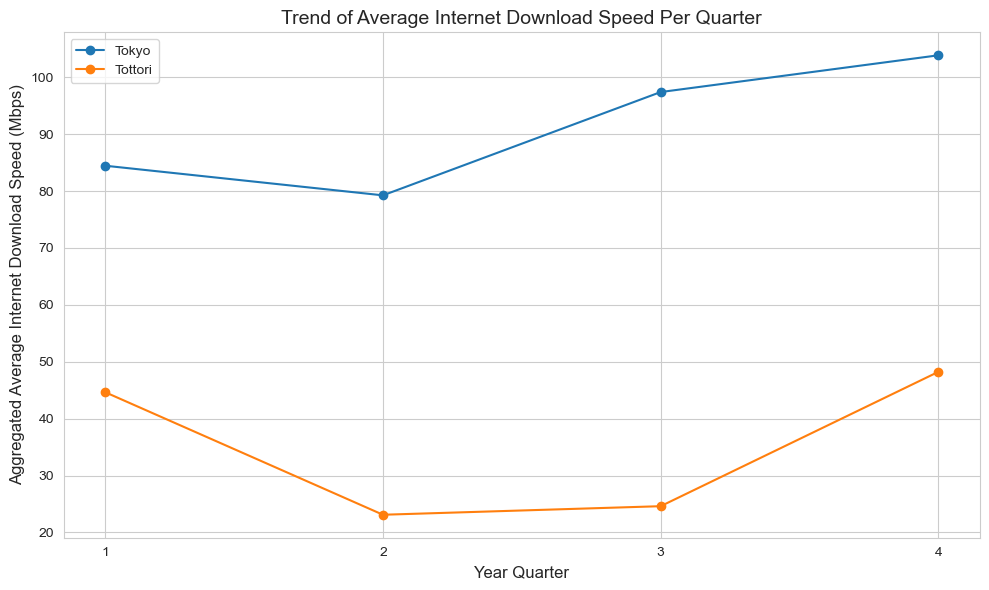

In [ ]:
import matplotlib.pyplot as plt

# Calculate average internet download speed per quarter for each city
average_data = df2.groupby(['city', 'Quarter'], as_index=False)['avg_d_mbps'].mean()

# Filter the data for the selected cities
selected_cities = ["Tokyo", "Tottori"]
filtered_average_data = average_data[average_data['city'].isin(selected_cities)]

# Plot the trend of average download speed over time for the selected cities
plt.figure(figsize=(10, 6))
for city in selected_cities:
    city_data = filtered_average_data[filtered_average_data['city'] == city]
    plt.plot(
        city_data['Quarter'],
        city_data['avg_d_mbps'],
        label=city,
        marker='o'
    )

plt.title("Trend of Average Internet Download Speed Per Quarter", fontsize=14)
plt.xlabel("Year Quarter", fontsize=12)
plt.ylabel("Aggregated Average Internet Download Speed (Mbps)", fontsize=12)
plt.xticks(ticks=range(1, 5), labels=['1', '2', '3', '4'], fontsize=10)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


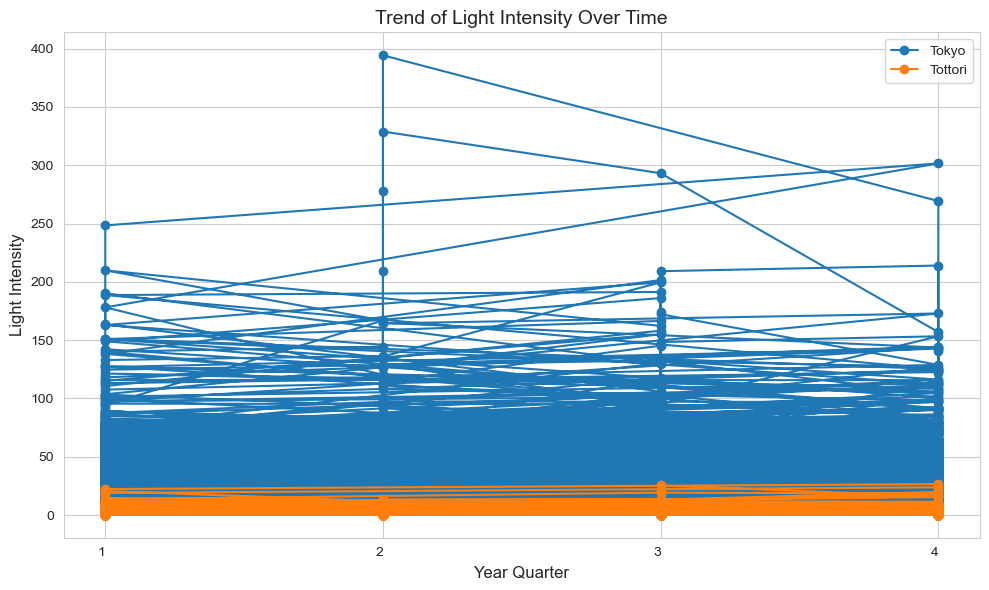

In [ ]:
# Plot for radiance
metric = 'light_intensity'  # Replace with the actual column name for radiance

plt.figure(figsize=(10, 6))
for city in selected_cities:
    city_data = filtered_data[filtered_data['city'] == city]
    plt.plot(
        city_data['Quarter'],
        city_data[metric],
        label=city,
        marker='o'
    )

plt.title(f"Trend of {metric.replace('_', ' ').title()} Over Time", fontsize=14)
plt.xlabel("Year Quarter", fontsize=12)
plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
plt.xticks(ticks=[1, 2, 3, 4], labels=['1', '2', '3', '4'], ha="right", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


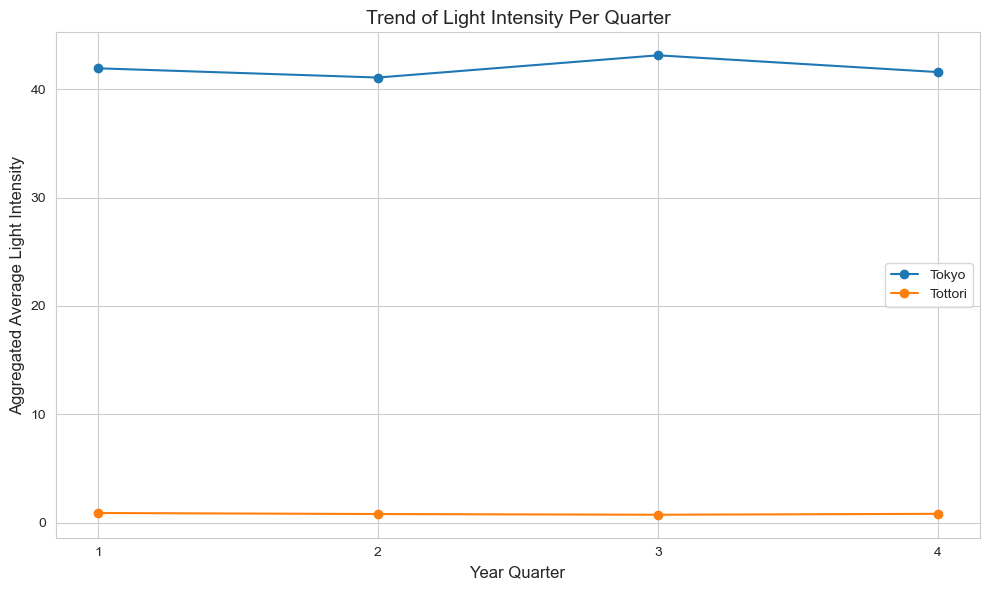

In [ ]:
import matplotlib.pyplot as plt

# Calculate average internet download speed per quarter for each city
average_data = df2.groupby(['city', 'Quarter'], as_index=False)['light_intensity'].mean()

# Filter the data for the selected cities
selected_cities = ["Tokyo", "Tottori"]
filtered_average_data = average_data[average_data['city'].isin(selected_cities)]

# Plot the trend of average download speed over time for the selected cities
plt.figure(figsize=(10, 6))
for city in selected_cities:
    city_data = filtered_average_data[filtered_average_data['city'] == city]
    plt.plot(
        city_data['Quarter'],
        city_data['light_intensity'],
        label=city,
        marker='o'
    )

plt.title("Trend of Light Intensity Per Quarter", fontsize=14)
plt.xlabel("Year Quarter", fontsize=12)
plt.ylabel("Aggregated Average Light Intensity", fontsize=12)
plt.xticks(ticks=range(1, 5), labels=['1', '2', '3', '4'], fontsize=10)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


# Hypothesis Testing

Download Correlation between light intensity and average download speed: 0.36, P-value: 0.000000
Upload Correlation between light intensity and average upload speed: 0.29, P-value: 0.000000
Latency Correlation with average download speed: -0.30, P-value: 0.0000
Latency Correlation with average upload speed: -0.26, P-value: 0.0000


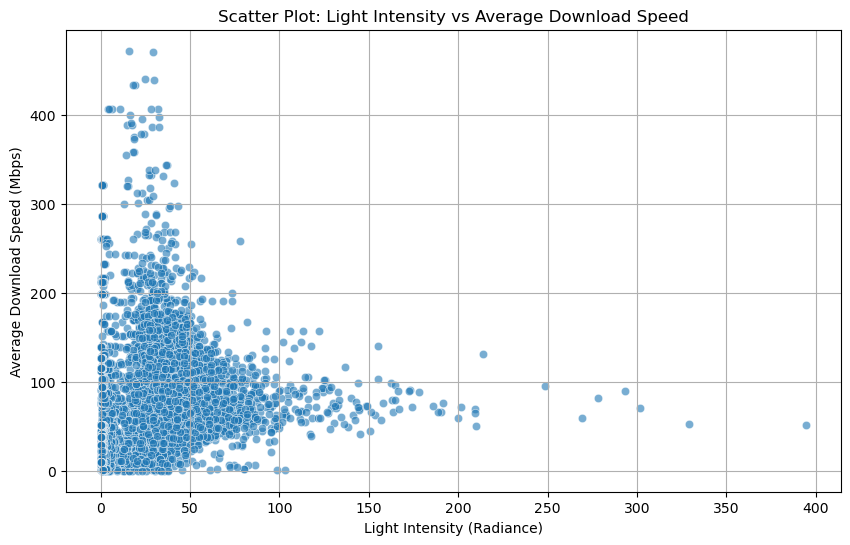

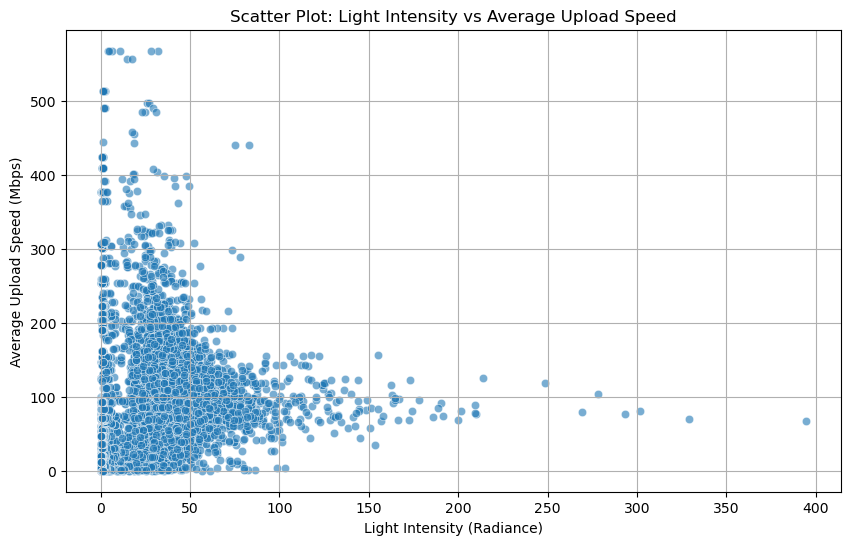

Smart City Download Correlation: -0.07, P-value: 0.0000
Developing City Download Correlation: 0.12, P-value: 0.0000
Smart City Latency Correlation: -0.25, P-value: 0.0000
Developing City Latency Correlation: -0.19, P-value: 0.0000


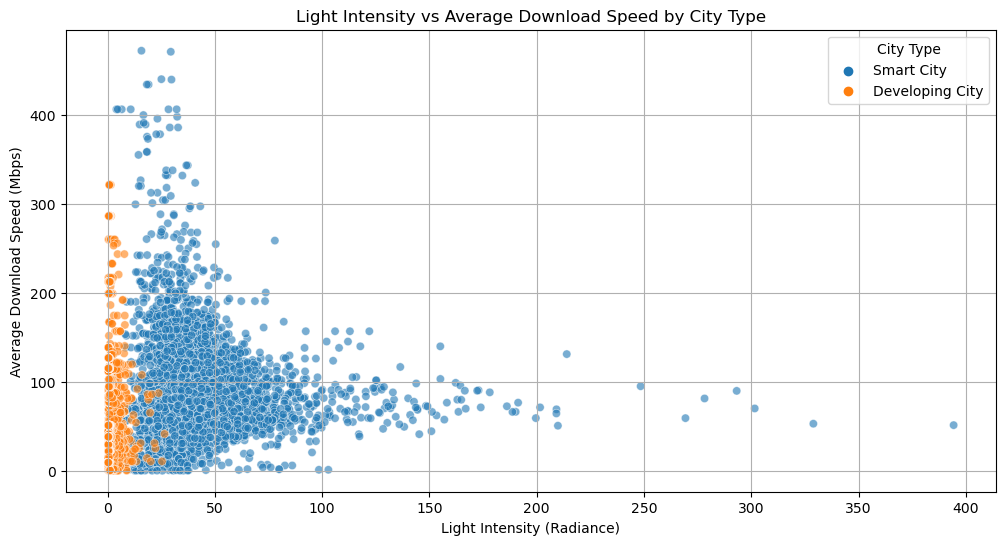

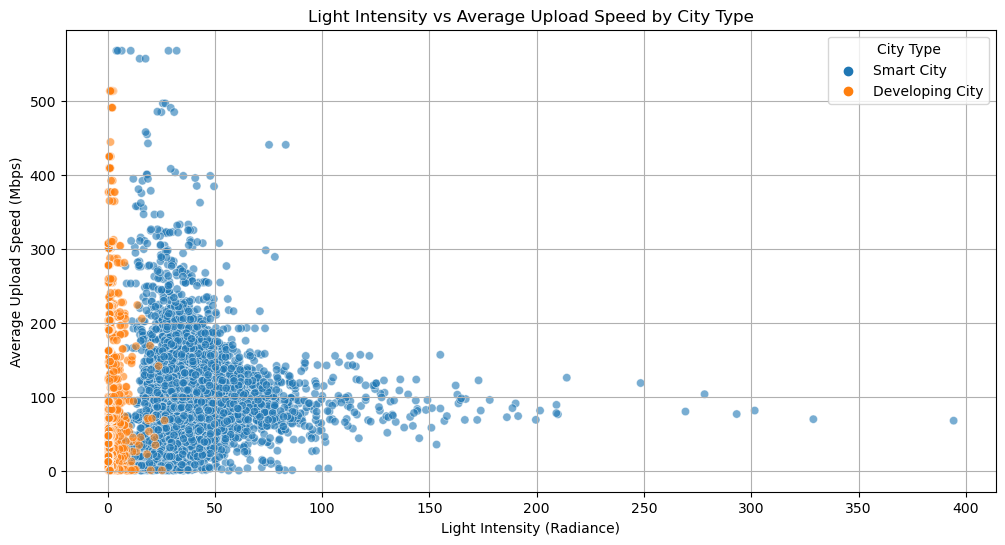

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load data
df = pd.read_csv('Merged_clean.csv')

# Null Hypothesis: nighttime light intensity have no relation with internet speed.
# Additionally, explore the relationship of average latency, number of tests, and devices.

download_correlation, download_p_value = pearsonr(df['light_intensity'], df['avg_d_mbps'])
upload_correlation, upload_p_value = pearsonr(df['light_intensity'], df['avg_u_mbps'])  # Assuming 'avg_u_mbps' is the upload speed column

latency_download_corr, latency_download_p = pearsonr(df['avg_lat_ms'], df['avg_d_mbps'])
latency_upload_corr, latency_upload_p = pearsonr(df['avg_lat_ms'], df['avg_u_mbps'])

print(f"Download Correlation between light intensity and average download speed: {download_correlation:.2f}, P-value: {download_p_value:.6f}")
print(f"Upload Correlation between light intensity and average upload speed: {upload_correlation:.2f}, P-value: {upload_p_value:.6f}")
print(f"Latency Correlation with average download speed: {latency_download_corr:.2f}, P-value: {latency_download_p:.4f}")
print(f"Latency Correlation with average upload speed: {latency_upload_corr:.2f}, P-value: {latency_upload_p:.4f}")

# Scatter plots
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='light_intensity', y='avg_d_mbps', alpha=0.6)
plt.title('Scatter Plot: Light Intensity vs Average Download Speed')
plt.xlabel('Light Intensity (Radiance)')
plt.ylabel('Average Download Speed (Mbps)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='light_intensity', y='avg_u_mbps', alpha=0.6)  # Assuming 'avg_u_mbps' is the upload speed column
plt.title('Scatter Plot: Light Intensity vs Average Upload Speed')
plt.xlabel('Light Intensity (Radiance)')
plt.ylabel('Average Upload Speed (Mbps)')
plt.grid(True)
plt.show()

# Categorize city type based on city names
df['city_type'] = np.where(df['city'] == 'Tokyo', 'Smart City',
                           np.where(df['city'] == 'Tottori', 'Developing City', 'Other'))

# Filter correlations for Smart and Developing cities
smart_city_download_corr = df[df['city_type'] == 'Smart City'][['light_intensity', 'avg_d_mbps']]
developing_city_download_corr = df[df['city_type'] == 'Developing City'][['light_intensity', 'avg_d_mbps']]

smart_download_corr, smart_download_p = pearsonr(smart_city_download_corr['light_intensity'], smart_city_download_corr['avg_d_mbps'])
developing_download_corr, developing_download_p = pearsonr(developing_city_download_corr['light_intensity'], developing_city_download_corr['avg_d_mbps'])

print(f"Smart City Download Correlation: {smart_download_corr:.2f}, P-value: {smart_download_p:.4f}")
print(f"Developing City Download Correlation: {developing_download_corr:.2f}, P-value: {developing_download_p:.4f}")

smart_city_latency_corr = df[df['city_type'] == 'Smart City'][['avg_lat_ms', 'avg_d_mbps']]
developing_city_latency_corr = df[df['city_type'] == 'Developing City'][['avg_lat_ms', 'avg_d_mbps']]

smart_latency_corr, smart_latency_p = pearsonr(smart_city_latency_corr['avg_lat_ms'], smart_city_latency_corr['avg_d_mbps'])
developing_latency_corr, developing_latency_p = pearsonr(developing_city_latency_corr['avg_lat_ms'], developing_city_latency_corr['avg_d_mbps'])

print(f"Smart City Latency Correlation: {smart_latency_corr:.2f}, P-value: {smart_latency_p:.4f}")
print(f"Developing City Latency Correlation: {developing_latency_corr:.2f}, P-value: {developing_latency_p:.4f}")

# Scatter plots by city type
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='light_intensity', y='avg_d_mbps', hue='city_type', alpha=0.6)
plt.title('Light Intensity vs Average Download Speed by City Type')
plt.xlabel('Light Intensity (Radiance)')
plt.ylabel('Average Download Speed (Mbps)')
plt.legend(title='City Type')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='light_intensity', y='avg_u_mbps', hue='city_type', alpha=0.6)
plt.title('Light Intensity vs Average Upload Speed by City Type')
plt.xlabel('Light Intensity (Radiance)')
plt.ylabel('Average Upload Speed (Mbps)')
plt.legend(title='City Type')
plt.grid(True)
plt.show()

In [ ]:
df = pd.read_csv('Merged_clean.csv')
df

,longitude,latitude,light_intensity,city,avg_lat_ms,tests,devices,avg_d_mbps,avg_u_mbps,Quarter
0,139.562501,35.829167,21.827122,Tokyo,10.0,11.0,4.0,96.278,45.465,4.0
1,139.566668,35.829167,20.948105,Tokyo,26.0,13.0,8.0,61.070,66.985,1.0
2,139.570834,35.829167,23.337433,Tokyo,19.0,21.0,9.0,119.455,90.585,4.0
3,139.575001,35.829167,25.592182,Tokyo,19.0,21.0,9.0,119.455,90.585,4.0
4,139.579168,35.829167,24.239080,Tokyo,10.0,26.0,11.0,88.415,85.376,2.0
...,...,...,...,...,...,...,...,...,...,...
11147,134.479168,35.362500,0.320583,Tottori,16.0,1.0,1.0,9.271,12.137,1.0
11148,134.483334,35.362500,0.277542,Tottori,16.0,1.0,1.0,9.271,12.137,1.0
11149,134.487501,35.362500,0.281790,Tottori,16.0,1.0,1.0,9.271,12.137,1.0
11150,134.491668,35.362500,0.302659,Tottori,16.0,1.0,1.0,9.271,12.137,1.0


In [ ]:
from scipy.stats import norm

# Define groups
smart_city = df[df['city'] == 'Tokyo']['avg_d_mbps']
developing_city = df[df['city'] == 'Tottori']['avg_d_mbps']

# Compute statistics
mean_diff = smart_city.mean() - developing_city.mean()
n1, n2 = len(smart_city), len(developing_city)
std1, std2 = smart_city.std(), developing_city.std()

# Pooled standard error
pooled_se = np.sqrt(std1**2 / n1 + std2**2 / n2)

# Z-test statistic
z_stat = mean_diff / pooled_se

# Two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

print(f"Z-test statistic: {z_stat:.2f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print("Reject the null hypothesis: Significant difference between the two groups.")
else:
    print("Fail to reject the null hypothesis: No significant difference between the two groups.")


Z-test statistic: 56.99
P-value: 0.000000
Reject the null hypothesis: Significant difference between the two groups.


In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table: Count how many cities fall above/below a download speed threshold
threshold = df['avg_d_mbps'].median()  # Use median as a threshold
contingency_table = pd.crosstab(df['city'], df['avg_d_mbps'] > threshold)

# Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

if p_value < 0.05:
    print("Reject the null hypothesis: City type and download speed are not independent.")
else:
    print("Fail to reject the null hypothesis: City type and download speed are independent.")


Chi-square statistic: 5000.90
P-value: 0.000000
Degrees of Freedom: 1
Expected Frequencies:
[[2323.40746055 2128.59253945]
 [3496.59253945 3203.40746055]]
Reject the null hypothesis: City type and download speed are not independent.


# Predication Model

## LR For Download Speed

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

data = pd.read_csv('Merged_clean.csv')


X = data.drop(["city", "latitude", "longitude", "avg_d_mbps"], axis=1)
y = data['avg_d_mbps']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train)

# Make predictions on both the training and testing data
y_train_pred = linear_model.predict(X_train_scaled)
y_test_pred = linear_model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training R^2 Score:", train_r2)
print("Testing R^2 Score:", test_r2)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)


Training R^2 Score: 0.7251237881930506
Testing R^2 Score: 0.7131373122035811
Training Mean Squared Error: 927.814212679361
Testing Mean Squared Error: 1032.121897392108


Feature Importance:
           Feature  Coefficient  Absolute_Coefficient
4       avg_u_mbps    45.429643             45.429643
0  light_intensity     8.409611              8.409611
3          devices    -4.535560              4.535560
2            tests     3.593093              3.593093
1       avg_lat_ms    -3.587450              3.587450
5          Quarter     2.153506              2.153506


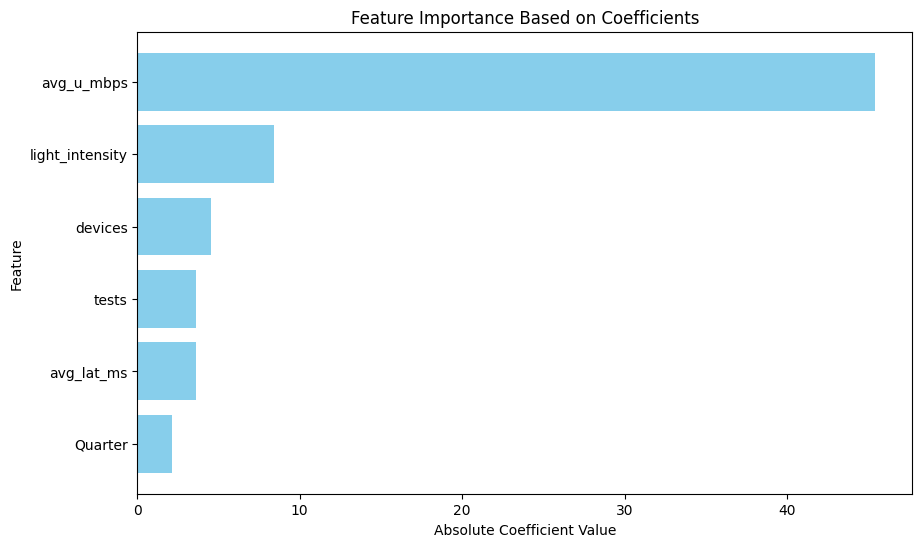

In [ ]:
import numpy as np

feature_names = X.columns

coefficients = linear_model.coef_

feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Absolute_Coefficient": np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by="Absolute_Coefficient", ascending=False)

print("Feature Importance:")
print(feature_importance)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Absolute_Coefficient'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importance Based on Coefficients')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()


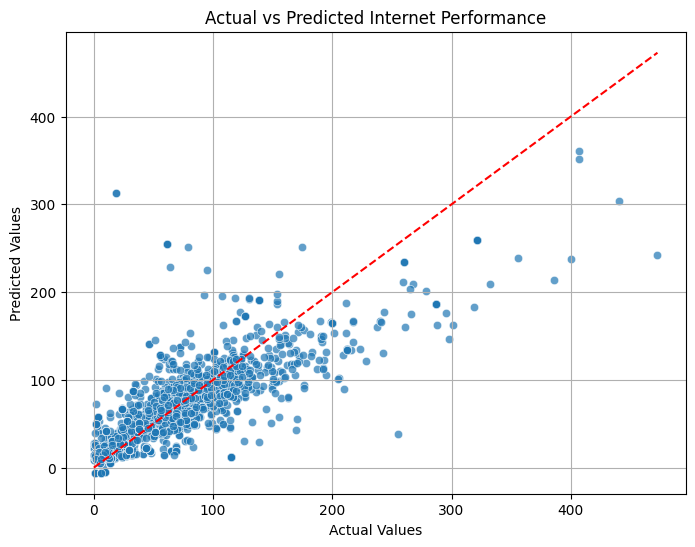

In [ ]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Internet Performance')
plt.grid(True)
plt.show()


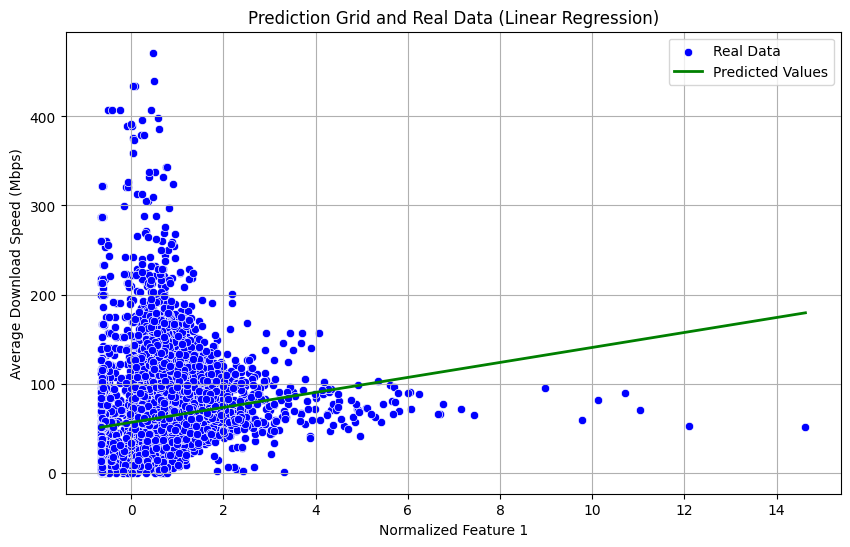

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a grid of prediction points for the first feature
prediction_grid = np.linspace(X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max(), 100).reshape(-1, 1)

# Add zeros for the remaining features
prediction_grid_full = np.hstack((prediction_grid, np.zeros((prediction_grid.shape[0], X_train_scaled.shape[1] - 1))))

# Predict values using the linear regression model
predicted_grid_values = linear_model.predict(prediction_grid_full)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_scaled[:, 0], y=y_train, color='blue', label='Real Data')
plt.plot(prediction_grid[:, 0], predicted_grid_values, color='green', label='Predicted Values', linewidth=2)
plt.xlabel('Normalized Feature 1')
plt.ylabel('Average Download Speed (Mbps)')
plt.title('Prediction Grid and Real Data (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation using the linear regression model
scores = cross_val_score(linear_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"Cross-validated R-squared scores: {scores}")
print(f"Average R-squared: {scores.mean():.2f}")


Cross-validated R-squared scores: [0.74479341 0.7149481  0.74489126 0.69993429 0.7136303 ]
Average R-squared: 0.72
